## Before models

Before to do our 26 labels classification tasks, I want to check if the models can well classifier  - 

* ASL/Alphabet 
* Vision/Imagination

Noted: In this notebook, I didn't try ablation experiments due to time pressure, but it's better to give a try.

### Import Packages

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# our own pipeline
from pipelines.data_prapare import pack_data
# from pipelines.tools import plot_intervals
from pipelines.tools import power_band, one_signal_band_power, power_band_timeslice
from pipelines.data_prapare import read_orginal_data, read_power_band_txt,read_features_table

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, GRU, Dense, LSTM, RNN, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# pip install shap
# pip install lime
import shap
import lime
from sklearn.tree import export_graphviz, plot_tree

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# import sys
# sys.path.append('/content/gdrive/My Drive/UMONS')

### Some useful functions

All functions has a short description inside. And they are also in pipelines.ml_functions.py

In [6]:
def set_seed(seed=42):
    '''
    set all random seed to 42

    '''   
    random.seed(seed) # python
    np.random.seed(seed) # numpy
    torch.manual_seed(seed) # pytorch
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
set_seed()

In [8]:
def clean_all_feature_table(df, norm=True, norm_type='minmax', inf_times=2):
    '''
    replace inf data in our DF, and can choose whether to normalize or not
    PS: if choose to normalize feature tables, do it before split data
        
    Args:
    -----
            df (dataframe): feature tabels, without column label and column label_index
            norm (bool): normalize features or not
            norm_type(str): minmax or standard
            inf_times: replace INF and give them values like max_column*inf_times
    
    Return:
            df_new: 2-d np array
    '''
    df_new = df.copy()
    df_new.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_new = df_new.fillna(df_new.max()*inf_times)
    
    if not norm:
        return df_new
    else:
        if norm_type == 'minmax':
            mm = MinMaxScaler()
            df_new = mm.fit_transform(np.array(df_new))
        elif norm_type == 'standard':
            sd = StandardScaler()
            df_new = sd.fit_transform(np.array(df_new))
        else:
            raise ValueError
            
    return df_new

In [9]:
def plot_pca(X):
    '''
    Plot Principal Component Analysis cumulative of the explained variance
        
    Args:
    ----- 
            X (DataFrame): feature DataFrame
                            
    '''
    pca_sk = PCA()
    pca_sk.fit(X)

    # plotting the cumulative summation of the explained variance
    plt.figure()
    plt.plot(np.cumsum(pca_sk.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')  # for each component
    plt.title('Segmentation Dataset Explained Variance')
    plt.show(block=True)

In [10]:
def print_performance(y_true, y_pred):
    '''
    Display performance of classifier by comparing classes. Used parameters to describe performance are accuracy, f1 score, recall and precision.
        
    Args:
    -----
            y_true (list): classes for every row of X
            y_pred (list): classes predicted by classifier

    '''
    accuracy = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='macro')
    recall_w = recall_score(y_true, y_pred, average='macro')
    precision_w = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    print('accuracy: %.3f'%accuracy)
    print('f1 score macro av: %.3f'%f1_w)
    print('recall score macro av: %.3f'%recall_w)
    print('precision score macro av: %.3f'%precision_w)
    print('f1 score for every class: ',f1)
    print('recall: ', recall)
    print('precision: ', precision)
    print(' ')
    return accuracy, f1_w, recall_w, precision_w,  f1, recall, precision

In [11]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    '''
    Perform 10fold crossvalidation, fit model with train data and evaluate its performance 
    with print_performance() function and confusion matrix.
        
    Args:
    -----
        
            model (object): classifier object
            X_train (pd.DataFrame or np.array): feature matrix for train set
            y_train (list): classes for train set
            X_test (pd.DataFrame or np.array):feature matrix for test set
            y_test (list): classes for test set
    
    '''
    print(model.__class__.__name__)
    print('Cross-validation')
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print('Accuracy: ', scores)
    print('Mean accuracy:  %0.3f (+/- %0.3f)' % (scores.mean(), scores.std()))
    print('')
    
    model.fit(X_train, y_train)

    
    y_pred_test = model.predict(X_test)

    print('Test')
    print_performance(y_test, y_pred_test)

    print('Confusion matrix')
    
    
    plot_confusion_matrix(model, X_test, y_test, normalize='pred', display_labels=['EO', 'EC'],values_format='.3f')   
    plt.show()

In [12]:
def model_evaluation_dict(X, y, model, model_name, params):
    '''
    Perform 10 fold crossvalidation, fit model with train data and evaluate its performance 
    return performance dict
            
    '''
    
    clf = GridSearchCV(model, params, cv=10)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf.fit(X_train, y_train)
    params = clf.best_params_
    
    Training_score = clf.score(X_train, y_train) 
    Score = clf.score(X_test, y_test) 
    Whole_score = clf.score(X, y) 
    cvres = clf.cv_results_ 
    cvscore = cvres['mean_test_score'][clf.best_index_] 
    macro_precision, macro_recall, macro_f1_score, macro_support=\
    precision_recall_fscore_support(y_test, clf.predict(X_test), average='macro') 
    micro_precision, micro_recall, micro_f1_score, micro_support=\
    precision_recall_fscore_support(y_test, clf.predict(X_test), average='micro') 
    if not params:
        # empty params dict
        params = 'default'
    # return a dictionary
    d_info = {'Classifier': model_name,'param':params,'Traing score': Training_score,' Test Score': Score, \
              'Whole score': Whole_score, 'CV Score':cvscore, \
         'Precision(Macro)': macro_precision, 'Precision(Micro)': micro_precision,\
         'Recall(Macro)': macro_recall, 'Recall(Micro)': micro_recall,\
         'F1 Score(Macro)': macro_f1_score, 'F1 Score(Micro)': micro_f1_score}

    
    return d_info

In [13]:
def init_classifiers():
    '''
    Initialize our machine learning classifier --- 
    where catboost and NN (neural network classification) are not initialized, 
    and most hyperparameters will take default values
            
    '''
    
    model_names = ['SVM','LR','KNN','GBDT','DT','AdaB', 'RF','XGB','LGB','Catboost','NN']

    # the training parameters of each model
    param_grid_svc = [{}]
    param_grid_logistic = [{'C':[0.1], 'penalty':['l1','l2']}]
    param_grid_knn = [{},{'n_neighbors':list(range(3,8))}]
    param_grid_gbdt = [{}]
    param_grid_tree = [{}]
    param_grid_boost = [{}]
    param_grid_rf = [{}]
    param_grid_xgb = [{}]
    param_grid_lgb = [{}]

    return([(SVC(), model_names[0], param_grid_svc), 
            (LogisticRegression(), model_names[1], param_grid_logistic),
            (KNeighborsClassifier(), model_names[2], param_grid_knn),
            (GradientBoostingClassifier(), model_names[3], param_grid_gbdt),
            (DecisionTreeClassifier(), model_names[4], param_grid_tree),
            (AdaBoostClassifier(), model_names[5], param_grid_boost),
            (RandomForestClassifier(), model_names[6], param_grid_rf),
            (xgb.XGBClassifier(), model_names[7], param_grid_xgb),
            (lgb.sklearn.LGBMClassifier(), model_names[8], param_grid_lgb)
           ])

### Read features data

In [14]:
aat_vis, aat_img, asl_vis, asl_img = read_features_table()
labels = np.array(aat_vis['label_index'])
bp_data_dict = read_power_band_txt()

# for the feature analyse
col_name = list(asl_img.columns)[2:]
# col_name

In [15]:
bp_data_dict.keys()

dict_keys(['fft_alphabet_imagination', 'fft_alphabet_vision', 'fft_asl_imagination', 'fft_asl_vision', 'multitaper_alphabet_imagination', 'multitaper_alphabet_vision', 'multitaper_asl_imagination', 'multitaper_asl_vision', 'welch_alphabet_imagination', 'welch_alphabet_vision', 'welch_asl_imagination', 'welch_asl_vision'])

In [16]:
aat_vis = clean_all_feature_table(aat_vis.iloc[:, 2:])
aat_img = clean_all_feature_table(aat_img.iloc[:, 2:])
asl_vis = clean_all_feature_table(asl_vis.iloc[:, 2:])
asl_img = clean_all_feature_table(asl_img.iloc[:, 2:])


bp_aat_img = np.array(bp_data_dict['welch_alphabet_imagination']).reshape(-1,80)
bp_aat_vis = np.array(bp_data_dict['welch_alphabet_vision']).reshape(-1,80)
bp_asl_img = np.array(bp_data_dict['welch_asl_imagination']).reshape(-1,80)
bp_asl_vis = np.array(bp_data_dict['welch_asl_vision']).reshape(-1,80)

# fft
bp_aat_img_fft = np.array(bp_data_dict['fft_alphabet_imagination']).reshape(-1,80)
bp_aat_vis_fft = np.array(bp_data_dict['fft_alphabet_vision']).reshape(-1,80)
bp_asl_img_fft = np.array(bp_data_dict['fft_asl_imagination']).reshape(-1,80)
bp_asl_vis_fft = np.array(bp_data_dict['fft_asl_vision']).reshape(-1,80)
# multitaper
bp_aat_img_multitaper = np.array(bp_data_dict['multitaper_alphabet_imagination']).reshape(-1,80)
bp_aat_vis_multitaper = np.array(bp_data_dict['multitaper_alphabet_vision']).reshape(-1,80)
bp_asl_img_multitaper = np.array(bp_data_dict['multitaper_asl_imagination']).reshape(-1,80)
bp_asl_vis_multitaper = np.array(bp_data_dict['multitaper_asl_vision']).reshape(-1,80)

In [17]:
np.array(bp_asl_vis).shape

(832, 80)

Another function just is used in this notebook

In [18]:
def binary_models_print(estimator, is_bp_features):
    if is_bp_features:
        x_train, x_test, y_train, y_test = train_test_split(data_bp_binary, labels_binary, test_size=0.3)
    else:
        x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary, labels_binary, test_size=0.3)
    
    estimator.fit(x_train, y_train)
    
    if is_bp_features:
        print("BP Features ---> For test dataset: ")
    else:
        print("All Features ---> For test dataset")
    y_pred = estimator.predict(x_test)
    accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, y_pred)
    t1 = [accuracy, f1_w, recall_w, precision_w,  f1, recall, precision]

    print()
    if is_bp_features:
        print("BP Features ---> For whole dataset: ")
        y_pred = estimator.predict(data_bp_binary)
    else:
        print("All Features ---> For whole dataset")
        y_pred = estimator.predict(data_allfeature_binary)
    accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(labels_binary, y_pred)
    t2 = [accuracy, f1_w, recall_w, precision_w,  f1, recall, precision]
    
    return t1, t2

In [19]:
# aat_vis

## Binary classification - Imagination and Vision

### Model performances comparison

#### aat img vs aat vis

In [19]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary = np.concatenate((bp_aat_img, bp_aat_vis), axis=0)
data_allfeature_binary = np.concatenate((aat_img, aat_vis), axis=0) 

Use our function above to process a list of models and get their results in a table for a better observation and comparison:

PS: We can find with default params, the machine is already not bad, so I won't use GridSearchCV/RandomizedSearchCV to search the best params! This also means the models' performance could be improved.

In [26]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.520619        0.456   
1         DT                      default      1.000000        0.660   
2         LR  {'C': 0.1, 'penalty': 'l2'}      0.625430        0.660   
3        KNN                      default      0.778351        0.686   
4         RF                      default      1.000000        0.734   
5       GBDT                      default      0.955326        0.752   
6       AdaB                      default      0.860825        0.754   
7        XGB                      default      1.000000        0.788   
8        LGB                      default      1.000000        0.802   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.501202  0.518037          0.228457             0.456       0.497817   
1     0.897837  0.673460          0.659807             0.660       0.659991   
2     0.635817  0.617639          0.661289             0.660       0.661662   
3     0.750601  0.664861          0.691111             0.686       0.689978   
4     0.920072  0.776592          0.733452             0.734       0.734748   
5     0.894231  0.767956          0.752000             0.752       0.752016   
6     0.828726  0.729428          0.754353             0.754       0.754618   
7     0.936298  0.783503          0.790984             0.788       0.790704   
8     0.940505  0.771441          0.803512             0.802       0.802681   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.456         0.313187            0.456  
1          0.660         0.659804            0.660  
2          0.660         0.659951            0.660  
3          0.686         0.685898            0.686  
4          0.734         0.733436            0.734  
5          0.752         0.751996            0.752  
6          0.754         0.753975            0.754  
7          0.788         0.787997            0.788  
8          0.802         0.801936            0.802

If we only use band power features, we could find the performance of the model is relatively fluctuating, but even the best model has only an accuracy of 80% on the test set.(Even if this value can be improved by best params, it will not exceed 90%). But still, we could say, basically only BP features are possible to distinguish whether the signal is imaginary or visual.

(Of course, we can consider whether the BP feature with signal location information will perform better, which we will discuss in the future;

There is another part that needs to be discussed here, the reasons for the overfitting of the models. There may be many reasons for overfitting, but I am more inclined that the BP feature here is only a part of the robustness feature, so forcibly fitting will not get our ideal upper bound of 100%, our classifier lack enough information)

In [27]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0       GBDT                      default           1.0        0.994   
1       AdaB                      default           1.0        0.994   
2         DT                      default           1.0        0.996   
3        KNN                      default           1.0        0.996   
4        SVM                      default           1.0        1.000   
5         LR  {'C': 0.1, 'penalty': 'l2'}           1.0        1.000   
6         RF                      default           1.0        1.000   
7        XGB                      default           1.0        1.000   
8        LGB                      default           1.0        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.998197  1.000000          0.993869             0.994       0.994099   
1     0.998197  0.994857          0.994030             0.994       0.993975   
2     0.998798  0.998291          0.995996             0.996       0.995996   
3     0.998798  0.998291          0.995998             0.996       0.995998   
4     1.000000  1.000000          1.000000             1.000       1.000000   
5     1.000000  1.000000          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  0.996559          1.000000             1.000       1.000000   
8     1.000000  0.998291          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.994         0.993980            0.994  
1          0.994         0.993999            0.994  
2          0.996         0.995996            0.996  
3          0.996         0.995998            0.996  
4          1.000         1.000000            1.000  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

Compared to the table before, we can find whatever our ML model is, the machine could always get a high score, so as I just analyzed, BP is just a subset of our robustness feature/decision features.

And in section 2.2, I will analyze the feature importances to get a better view of our machines and features. Because this is not our final 26 classification task, I will just research the models in the second table!

#### asl vis vs asl img 

In [38]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary = np.concatenate((bp_asl_img, bp_asl_vis), axis=0)
data_allfeature_binary = np.concatenate((asl_img, asl_vis), axis=0)

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.508591        0.490   
1         DT                      default      1.000000        0.652   
2        KNN                      default      0.772337        0.662   
3         LR  {'C': 0.1, 'penalty': 'l2'}      0.680412        0.668   
4       AdaB                      default      0.826460        0.684   
5       GBDT                      default      0.931271        0.694   
6         RF                      default      1.000000        0.696   
7        LGB                      default      1.000000        0.726   
8        XGB                      default      1.000000        0.736   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.503005  0.510345          0.494980             0.490       0.499920   
1     0.895433  0.638351          0.652885             0.652       0.652796   
2     0.739183  0.652034          0.661791             0.662       0.661757   
3     0.676683  0.670034          0.667579             0.668       0.665945   
4     0.783654  0.700987          0.684332             0.684       0.685507   
5     0.859976  0.736222          0.693923             0.694       0.694231   
6     0.908654  0.738933          0.696457             0.696       0.696306   
7     0.917668  0.733731          0.727521             0.726       0.725456   
8     0.920673  0.718184          0.736370             0.736       0.736143   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.490         0.332289            0.490  
1          0.652         0.651994            0.652  
2          0.662         0.661771            0.662  
3          0.668         0.666071            0.668  
4          0.684         0.683590            0.684  
5          0.694         0.693852            0.694  
6          0.696         0.695981            0.696  
7          0.726         0.725199            0.726  
8          0.736         0.735962            0.736

An interesting point, compared to our first table, when doing the binary classification for ASL, the accuracy of the test set has dropped by close to 7%, which is kind of strange.

I think one possible reason is, this dataset was collected by myself, when recording the signal, I have no memory or cognition of the sign language letters in my mind, all my cognition are based on sound notice, so it is possible that the experiment in the ASL part is not as good as alphabet letter part(Ideally, the experimenter needs to remember all the letters by himself, or use it often), which may cause part of the brain not to concentrate on the sign letters(watch or imagine), so the BP feature will have some noise.(notice that this is just a guess)

In [39]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        KNN           {'n_neighbors': 7}      0.995704        0.988   
1         DT                      default      1.000000        0.996   
2       GBDT                      default      1.000000        0.996   
3        SVM                      default      1.000000        1.000   
4         LR  {'C': 0.1, 'penalty': 'l2'}      1.000000        1.000   
5       AdaB                      default      1.000000        1.000   
6         RF                      default      1.000000        1.000   
7        XGB                      default      1.000000        1.000   
8        LGB                      default      1.000000        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.993389  0.992263          0.987696             0.988       0.988385   
1     0.998798  0.999138          0.995987             0.996       0.995987   
2     0.998798  0.996559          0.995996             0.996       0.995996   
3     1.000000  1.000000          1.000000             1.000       1.000000   
4     1.000000  1.000000          1.000000             1.000       1.000000   
5     1.000000  0.996559          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  0.997421          1.000000             1.000       1.000000   
8     1.000000  1.000000          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.988         0.987977            0.988  
1          0.996         0.995987            0.996  
2          0.996         0.995996            0.996  
3          1.000         1.000000            1.000  
4          1.000         1.000000            1.000  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

The classification performance of the models in this table is also very good.


So we can draw the conclusion that the model can easily distinguish the visual signal and the imaginary signal without the need to adjust the parameters. There must be some very important decisive features, whether these features are frequency domain features or time domain features. How they could present signals and could neutral network learn those features without feature extraction?

Before carrying out the characteristic analysis, we classify all vision and imagination (832*2 each *2), without distinguishing between ASL and alphabet, and check the performance of classification.

#### vis vs img

In [40]:
labels_binary = [*[0 for i in range(832*2)], *[1 for i in range(832*2)]]
data_bp_binary = np.concatenate((bp_asl_img,bp_aat_img,bp_asl_vis, bp_aat_vis), axis=0)
data_allfeature_binary = np.concatenate((asl_img,aat_img,asl_vis, aat_vis), axis=0)

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.513096     0.509510   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.652641     0.633634   
2         DT                      default      1.000000     0.638639   
3        KNN           {'n_neighbors': 6}      0.757836     0.641642   
4       AdaB                      default      0.776299     0.702703   
5       GBDT                      default      0.876342     0.731732   
6         RF                      default      1.000000     0.736737   
7        LGB                      default      0.999571     0.756757   
8        XGB                      default      1.000000     0.764765   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.512019  0.527684          0.573080          0.509510       0.507132   
1     0.646935  0.647068          0.635470          0.633634       0.634707   
2     0.891526  0.652229          0.638665          0.638639       0.638672   
3     0.722957  0.662942          0.644011          0.641642       0.640311   
4     0.754207  0.693440          0.702660          0.702703       0.702587   
5     0.832933  0.735952          0.731602          0.731732       0.731836   
6     0.920974  0.745381          0.737548          0.736737       0.737312   
7     0.926683  0.747969          0.757782          0.756757       0.758024   
8     0.929387  0.733369          0.764768          0.764765       0.764774   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0       0.509510         0.364662         0.509510  
1       0.633634         0.633366         0.633634  
2       0.638639         0.638637         0.638639  
3       0.641642         0.638775         0.641642  
4       0.702703         0.702606         0.702703  
5       0.731732         0.731613         0.731732  
6       0.736737         0.736720         0.736737  
7       0.756757         0.756748         0.756757  
8       0.764765         0.764764         0.764765

Basically, the joint data results here is the average of the individual data performance(asl - aat)

In [41]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0         DT                      default      1.000000     0.994995   
1        KNN                      default      0.996994     0.995996   
2       GBDT                      default      1.000000     0.997998   
3        SVM                      default      1.000000     1.000000   
4         LR  {'C': 0.1, 'penalty': 'l2'}      1.000000     1.000000   
5       AdaB                      default      1.000000     1.000000   
6         RF                      default      1.000000     1.000000   
7        XGB                      default      1.000000     1.000000   
8        LGB                      default      1.000000     1.000000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.998498  0.996994          0.994845          0.994995       0.995183   
1     0.996695  0.994848          0.995848          0.995996       0.996116   
2     0.999399  0.994848          0.998012          0.997998       0.997992   
3     1.000000  1.000000          1.000000          1.000000       1.000000   
4     1.000000  1.000000          1.000000          1.000000       1.000000   
5     1.000000  0.998712          1.000000          1.000000       1.000000   
6     1.000000  1.000000          1.000000          1.000000       1.000000   
7     1.000000  1.000000          1.000000          1.000000       1.000000   
8     1.000000  0.999140          1.000000          1.000000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0       0.994995         0.994989         0.994995  
1       0.995996         0.995978         0.995996  
2       0.997998         0.997998         0.997998  
3       1.000000         1.000000         1.000000  
4       1.000000         1.000000         1.000000  
5       1.000000         1.000000         1.000000  
6       1.000000         1.000000         1.000000  
7       1.000000         1.000000         1.000000  
8       1.000000         1.000000         1.000000

Both visual and imaginary can be easily classified when using full features.

(It should be mentioned that here we do not use any feature selection techniques.)

### Band power comparison

In the notebook 5.2, we find that, the BP values of method multitaper and welch are very close, and FFT are different from the others.

And in the section before, we have tested welch BP, so I will test other two methods for 2.1.1 aat img vs aat vis:

In [20]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary_2 = np.concatenate((bp_aat_img_fft, bp_aat_vis_fft), axis=0)
data_bp_binary_3 = np.concatenate((bp_aat_img_multitaper, bp_aat_vis_multitaper), axis=0)

FFT:

In [21]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary_2, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.601375        0.598   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.646048        0.632   
2        KNN                      default      0.786082        0.642   
3         DT                      default      1.000000        0.646   
4       AdaB                      default      0.817869        0.684   
5       GBDT                      default      0.964777        0.724   
6        LGB                      default      1.000000        0.750   
7         RF                      default      1.000000        0.756   
8        XGB                      default      1.000000        0.768   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.600361  0.523983          0.600530             0.598       0.595878   
1     0.641827  0.615127          0.638739             0.632       0.637845   
2     0.742788  0.662356          0.642424             0.642       0.642098   
3     0.893630  0.666711          0.647225             0.646       0.646582   
4     0.777644  0.686391          0.685753             0.684       0.686830   
5     0.892428  0.771508          0.729172             0.724       0.726381   
6     0.924880  0.756079          0.752956             0.750       0.752830   
7     0.926683  0.734534          0.756244             0.756       0.756112   
8     0.930288  0.736214          0.768015             0.768       0.767122   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.598         0.592324            0.598  
1          0.632         0.631906            0.632  
2          0.642         0.641827            0.642  
3          0.646         0.645761            0.646  
4          0.684         0.683818            0.684  
5          0.724         0.723558            0.724  
6          0.750         0.749999            0.750  
7          0.756         0.755984            0.756  
8          0.768         0.767371            0.768

Multitaper:

In [22]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary_3, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.627148        0.616   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.627148        0.628   
2         DT                      default      1.000000        0.668   
3        KNN                      default      0.782646        0.694   
4       AdaB                      default      0.845361        0.734   
5         RF                      default      1.000000        0.748   
6       GBDT                      default      0.961340        0.756   
7        XGB                      default      1.000000        0.774   
8        LGB                      default      1.000000        0.790   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.623798  0.543081          0.623438             0.616       0.613789   
1     0.627404  0.613447          0.628999             0.628       0.628000   
2     0.900240  0.646736          0.668586             0.668       0.667723   
3     0.756010  0.652070          0.693590             0.694       0.693531   
4     0.811899  0.731985          0.733935             0.734       0.734014   
5     0.924279  0.762754          0.747525             0.748       0.747335   
6     0.899639  0.764574          0.754859             0.756       0.755597   
7     0.932091  0.784210          0.774020             0.774       0.774034   
8     0.936899  0.781786          0.790042             0.790       0.790000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.616         0.607401            0.616  
1          0.628         0.627278            0.628  
2          0.668         0.667468            0.668  
3          0.694         0.693557            0.694  
4          0.734         0.733948            0.734  
5          0.748         0.747418            0.748  
6          0.756         0.755118            0.756  
7          0.774         0.773999            0.774  
8          0.790         0.789992            0.790

For welch, best test ACC is 80.2%, for FFT the best test ACC is 76.8%, the best ACC for multitaper is 79%.

So welch > multitaper > FFT

### Feature importances

After getting our models comparison tables,I want to obtain what are the main, important factors/features that influence our model to classify vision and imagination signals!

Furthermore, can DL models get the same performances without feature engineering/extraction work? This will be a really good try.

In [20]:
def threshold_list(alist, threshold= 0.1):
    big_thres = [i for i in alist if i >= threshold]
    small_thres = [i for i in alist if i < threshold]
    return big_thres, small_thres

It is also possible to directly analyze visual and virtual without distinguishing between sign language and alphabet:

But in order to make our final result more unbiased, we decided to construct the final result from three dictionaries.

In [21]:
labels_binary_1 = [*[0 for i in range(832)], *[1 for i in range(832)]]
labels_binary_3 = [*[0 for i in range(832*2)], *[1 for i in range(832*2)]]

data_allfeature_binary_1 = np.concatenate((aat_img, aat_vis), axis=0)
data_allfeature_binary_2 = np.concatenate((asl_img, asl_vis), axis=0)
data_allfeature_binary_3 = np.concatenate((asl_img, aat_img, asl_vis, aat_vis), axis=0)

In [22]:
# col_name

#### LR

One important thing to be aware of is, for LR model feature important, in fact, they are the coefficients of the regression model, so this type importance not like feature importance of tree based models 

In [23]:
estimator = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_1, labels_binary_1, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
fe_dict = {}
for i in range(len(col_name)):
    fe_dict.setdefault(col_name[i], 0)
    fe_dict[col_name[i]] = estimator.coef_[0][i]
    
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

1.0


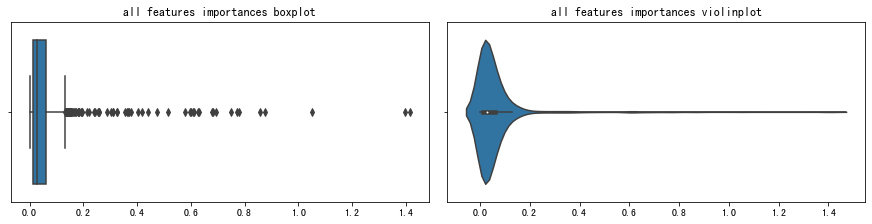

In [24]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value, ax=ax[0])
axesSub.set_title('all features importances boxplot')
axesSub = sns.violinplot(fe_list_value, ax=ax[1])
axesSub.set_title('all features importances violinplot')
plt.show()

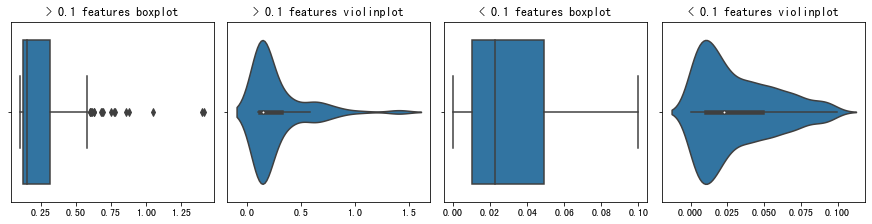

In [25]:
big, small = threshold_list(fe_list_value, threshold=0.1)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.1 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.1 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.1 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.1 features violinplot')
plt.show()

See barh plot for the top 10 whole feature (with channel):

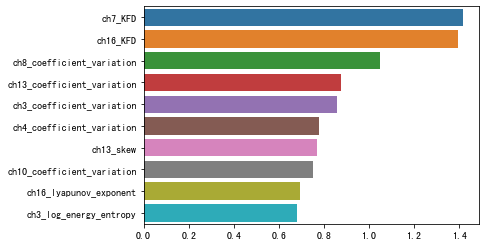

In [29]:
tt = fe_list[0:10]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

do the same for other combinations

In [31]:
estimator = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_2, labels_binary_1, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
fe_dict_2 = {}
for i in range(len(col_name)):
    fe_dict_2.setdefault(col_name[i], 0)
    fe_dict_2[col_name[i]] = estimator.coef_[0][i]
    
fe_list_2 = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)
# big, small = threshold_list(fe_list_value, threshold=0.1)

1.0


In [32]:
estimator = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
fe_dict_3 = {}
for i in range(len(col_name)):
    fe_dict_3.setdefault(col_name[i], 0)
    fe_dict_3[col_name[i]] = estimator.coef_[0][i]
    
fe_list_3 = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)
# big, small = threshold_list(fe_list_value, threshold=0.1)

1.0


Check these three dict and list:

Create an original DF, combine three dict/list;

Create a weighted DF, combine three dict/list and in this DF, add same features values.(comment codes)

In [35]:
threshold = 0.1
# LR_fe_dict = dict( )
LR_df_original = dict()
LR_df_original['channel'] = list()
LR_df_original['fe_names'] = list()
LR_df_original['fe_values'] = list()

for item in fe_list:
    if np.abs(item[1]) >= threshold:
        # LR_fe_dict[item[0]] = np.abs(item[1])
        tt = item[0].split('_')
    
        LR_df_original['fe_names'].append( ('_').join(tt[1:])  )
        LR_df_original['channel'].append(tt[0])
        LR_df_original['fe_values'].append(np.abs(item[1]))

# print(len(LR_fe_dict))

for item in fe_list_2:
    if np.abs(item[1]) >= threshold:
        
        tt = item[0].split('_')
        LR_df_original['channel'].append(tt[0])
        LR_df_original['fe_names'].append( ('_').join(tt[1:]) )
        LR_df_original['fe_values'].append(np.abs(item[1]))

#     if np.abs(item[1]) >= threshold and (item[0] not in LR_fe_dict.keys()):
#         LR_fe_dict[item[0]] = np.abs(item[1])
#     elif np.abs(item[1]) >= threshold and (item[0] in LR_fe_dict.keys()):
#         LR_fe_dict[item[0]] = np.abs(item[1]) + LR_fe_dict[item[0]]

        
for item in fe_list_3:
    if np.abs(item[1]) >= threshold:
        
        tt = item[0].split('_')
        LR_df_original['channel'].append(tt[0])
        LR_df_original['fe_names'].append( ('_').join(tt[1:]) )
        LR_df_original['fe_values'].append(np.abs(item[1]))
        
#     if np.abs(item[1]) >= threshold and (item[0] not in LR_fe_dict.keys()):
#         LR_fe_dict[item[0]] = np.abs(item[1])
#     elif np.abs(item[1]) >= threshold and (item[0] in LR_fe_dict.keys()):
#         LR_fe_dict[item[0]] = np.abs(item[1]) + LR_fe_dict[item[0]]  

We could analyze the features and the channels, which features are more important, which channels are more important, and compare the final results with other ML models' results:

In [36]:
# # LR_fe_dict
# LR_df_weigthed = dict()
# LR_df_weigthed['channel'] = list()
# LR_df_weigthed['full_names'] = list()
# LR_df_weigthed['fe_names'] = list()
# LR_df_weigthed['fe_values'] = list()

# for item in LR_fe_dict.items():
#     tt = item[0].split('_')
#     LR_df_weigthed['full_names'].append(item[0])
#     LR_df_weigthed['channel'].append(tt[0])
#     LR_df_weigthed['fe_names'].append( ('_').join(tt[1:])  )
#     LR_df_weigthed['fe_values'].append(item[1])
    
# LR_df_weigthed = pd.DataFrame(LR_df_weigthed)
LR_df_original = pd.DataFrame(LR_df_original)

In [37]:
# LR_df_fe = dict()
# for item in LR_fe_dict.items():
#     tt = item[0].split('_')
#     keys = ('_').join(tt[1:])
#     if keys in LR_df_fe.keys():
#         LR_df_fe[keys] += item[1]
#     else:
#         LR_df_fe[keys] = item[-1]
# LR_df_fe = pd.DataFrame({ 
# "fe_names":LR_df_fe.keys(),"fe_values":LR_df_fe.values()
# })

Start form our LR_df_original, choose two columns fe_names, fe_values, add the same values together, and then plot the barh plot.

Do the same for channel and fe_values.

In [66]:
tt = LR_df_original[['fe_names', 'fe_values']].groupby('fe_names')
tt =tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(10,)

pp = LR_df_original[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

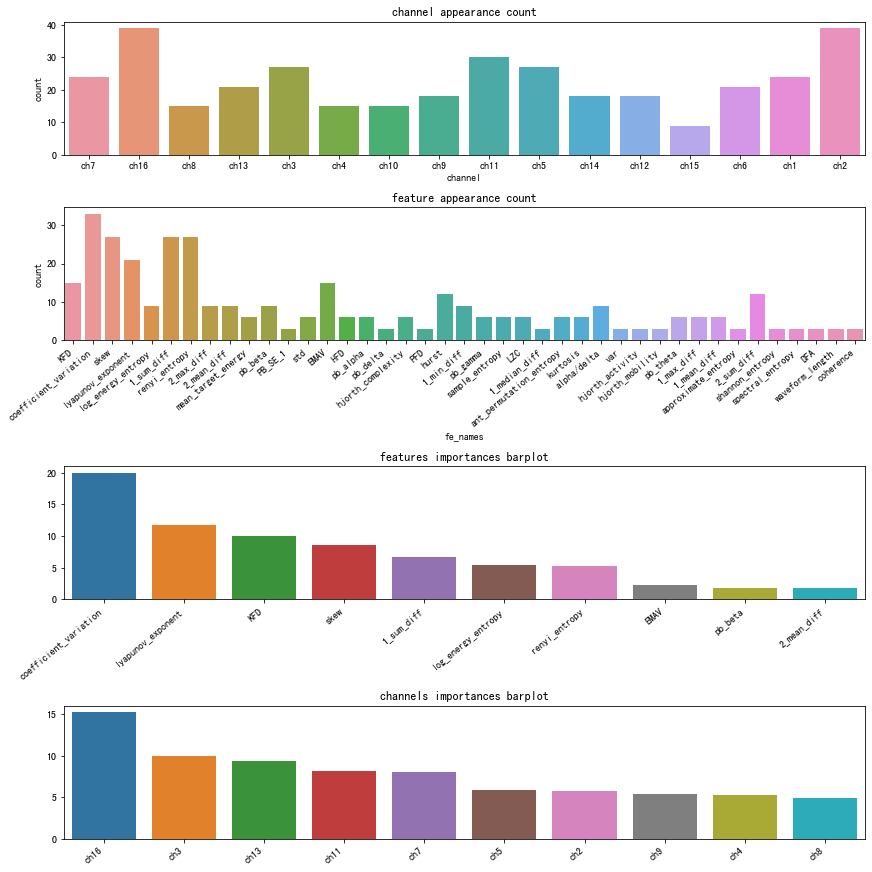

In [68]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = LR_df_original,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = LR_df_original,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

In our count plot, we could directly find that ch16 ch2 have a lot of features bigger than threshold, and there are a lot of  coefficient_variation, skew, 1_sum_diff, renyi_entropy features (> threshold);

In our barh plot, we could find our most importtant features are coefficient_variation, lyapunov_exponent etc, the most important channels are 16 and 3, 13.

Noted: The results obtained by the LR model are not very authoritative.

#### DecisionTree

In [32]:
estimator = DecisionTreeClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

# fe_dict = {}
# fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

0.997997997997998


In [136]:
# Counter(feat_importance)

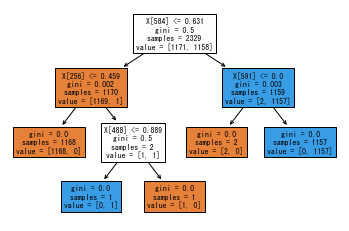

In [137]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
plot_tree(estimator,filled = True)
plt.show()

After verification, the three tree are always not deep, so try to adjust our tree and make them more complicated:

In [119]:
params = [{'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':list(range(3,12)), 'min_samples_split':list(range(2,12)),
          'min_samples_leaf':list(range(2,10))}]
model  = DecisionTreeClassifier()
estimator = GridSearchCV(model, params, cv=5)

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
params = estimator.best_params_

print(estimator.score(x_test, y_test))
# feat_importance = estimator.feature_importances_

0.994994994994995


In [121]:
params

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

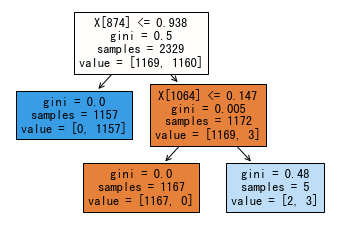

In [122]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
plot_tree(estimator.best_estimator_,filled = True)
plt.show()

In [144]:
col_name[1064]

'ch9_lyapunov_exponent'

For the decision tree model, basically 3 layers are enough for classification, so we couldn't get all features' importances, so I will pass it and check other tree based models.

But we can still find the coefficient_variation, lyapunov_exponent, entropy features are very important compared to other features!


#### RandomForest

In [69]:
estimator = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_1, labels_binary_1, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# t1, t2 = binary_models_print(estimator, is_bp_features=True)

1.0


In [70]:
# Counter(feat_importance)
# feat_importance

In [71]:
np.median(feat_importance)
np.min(feat_importance)
np.max(feat_importance)

0.05540309327624137

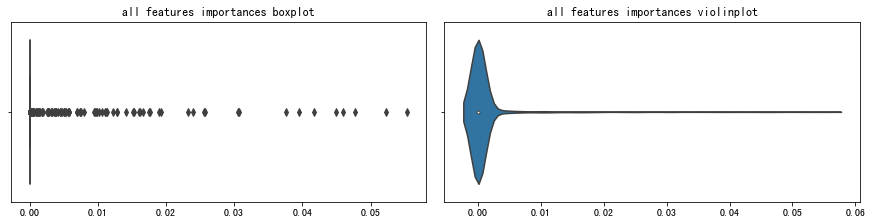

In [72]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value, ax=ax[0])
axesSub.set_title('all features importances boxplot')
axesSub = sns.violinplot(fe_list_value, ax=ax[1])
axesSub.set_title('all features importances violinplot')
plt.show()

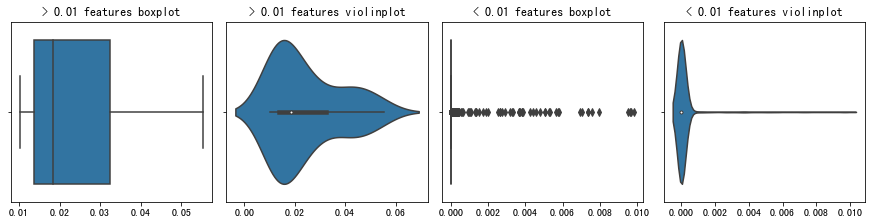

In [73]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

big, small = threshold_list(fe_list_value, threshold=0.01)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.01 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.01 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.01 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.01 features violinplot')
plt.show()

In [74]:
# 2
estimator = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_2, labels_binary_1, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict_2 = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list_2 = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# 3
estimator = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict_3 = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list_3 = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

1.0
1.0


In [75]:
threshold = 0.01
# RF_fe_dict = dict( )
RF_df_original = dict()
RF_df_original['channel'] = list()
RF_df_original['fe_names'] = list()
RF_df_original['fe_values'] = list()

for item in fe_list:
    if np.abs(item[1]) >= threshold:
        # RF_fe_dict[item[0]] = np.abs(item[1])
        tt = item[0].split('_')
    
        RF_df_original['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_values'].append(np.abs(item[1]))


for item in fe_list_2:
    if np.abs(item[1]) >= threshold:
        
        tt = item[0].split('_')
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_names'].append( ('_').join(tt[1:]) )
        RF_df_original['fe_values'].append(np.abs(item[1]))

#     if np.abs(item[1]) >= threshold and (item[0] not in RF_fe_dict.keys()):
#         RF_fe_dict[item[0]] = np.abs(item[1])
#     elif np.abs(item[1]) >= threshold and (item[0] in RF_fe_dict.keys()):
#         RF_fe_dict[item[0]] = np.abs(item[1]) + RF_fe_dict[item[0]]

        
for item in fe_list_3:
    if np.abs(item[1]) >= threshold:
        
        tt = item[0].split('_')
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_names'].append( ('_').join(tt[1:]) )
        RF_df_original['fe_values'].append(np.abs(item[1]))
        
#     if np.abs(item[1]) >= threshold and (item[0] not in RF_fe_dict.keys()):
#         RF_fe_dict[item[0]] = np.abs(item[1])
#     elif np.abs(item[1]) >= threshold and (item[0] in RF_fe_dict.keys()):
#         RF_fe_dict[item[0]] = np.abs(item[1]) + RF_fe_dict[item[0]]
     

# #  RF_fe_dict
# RF_df_weigthed = dict()
# RF_df_weigthed['channel'] = list()
# RF_df_weigthed['full_names'] = list()
# RF_df_weigthed['fe_names'] = list()
# RF_df_weigthed['fe_values'] = list()

# for item in RF_fe_dict.items():
#     tt = item[0].split('_')
#     RF_df_weigthed['full_names'].append(item[0])
#     RF_df_weigthed['channel'].append(tt[0])
#     RF_df_weigthed['fe_names'].append( ('_').join(tt[1:])  )
#     RF_df_weigthed['fe_values'].append(item[1])
    
# RF_df_weigthed = pd.DataFrame(RF_df_weigthed)
RF_df_original = pd.DataFrame(RF_df_original)


In [76]:
# RF_df_fe = dict()
# for item in RF_fe_dict.items():
#     tt = item[0].split('_')
#     keys = ('_').join(tt[1:])
#     if keys in RF_df_fe.keys():
#         RF_df_fe[keys] += item[1]
#     else:
#         RF_df_fe[keys] = item[-1]
# RF_df_fe = pd.DataFrame({ 
# "fe_names":RF_df_fe.keys(),"fe_values":RF_df_fe.values()
# })

In [77]:
tt = RF_df_original[['fe_names', 'fe_values']].groupby('fe_names')
tt =tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(10,)

pp = RF_df_original[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

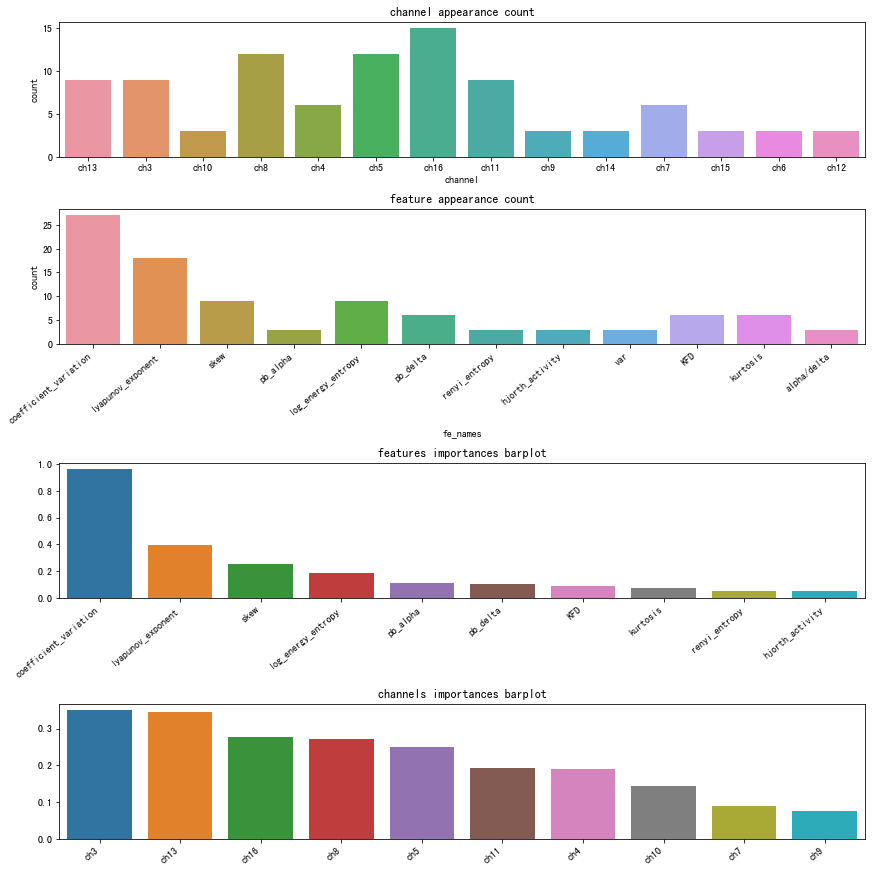

In [78]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

Channel 16 always has a lot of important features! in the RF models, there are no longer channel 2 features, which conflict with LR models. But in RF models, the most important channels are 16, 3, 13.

Compare with the feature part, basically all RF important features are in LR important features:

We could find our most important features ---> coefficient_variation, lyapunov_exponent, skew, log_energy_entropy, band power, KFD, etc.

(RF conclusion are more convincible than LR coefficients)

#### Boosting

For the boosting tree, they are very similar with our DT trees, so just check the case - data 3 - label 3:

Adaboost

In [179]:
estimator = AdaBoostClassifier()
# t1, t2 = binary_models_print(estimator, is_bp_features=True)

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

1.0


In [186]:
# Counter(feat_importance)

fe_list[:20]

[('ch11_coefficient_variation', 0.12),
 ('ch16_coefficient_variation', 0.12),
 ('ch9_lyapunov_exponent', 0.12),
 ('ch5_coefficient_variation', 0.1),
 ('ch14_coefficient_variation', 0.1),
 ('ch5_lyapunov_exponent', 0.1),
 ('ch9_1_sum_diff', 0.08),
 ('ch16_skew', 0.06),
 ('ch3_KFD', 0.04),
 ('ch5_alpha/delta', 0.02),
 ('ch6_renyi_entropy', 0.02),
 ('ch8_coefficient_variation', 0.02),
 ('ch9_coefficient_variation', 0.02),
 ('ch10_mean_target_energy', 0.02),
 ('ch11_alpha/delta', 0.02),
 ('ch16_PFD', 0.02),
 ('ch3_lyapunov_exponent', 0.02),
 ('ch1_min', 0.0),
 ('ch1_max', 0.0),
 ('ch1_std', 0.0)]

GBDT 

In [187]:
estimator = GradientBoostingClassifier()
# t1, t2 = binary_models_print(estimator, is_bp_features=True)

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

0.996996996996997


In [189]:
# Counter(feat_importance)
fe_list[:20]

[('ch16_coefficient_variation', 0.9931412298887137),
 ('ch11_1_sum_diff', 0.00342932678442229),
 ('ch5_lyapunov_exponent', 0.0009704589352608082),
 ('ch9_lyapunov_exponent', 0.0009132136267701257),
 ('ch16_peak', 0.00040067554837127566),
 ('ch15_var', 0.00021301753421281957),
 ('ch16_median', 0.00017267081380327483),
 ('ch3_PB_SE_3', 0.0001402262561166347),
 ('ch16_coherence', 0.00011403538480736755),
 ('ch1_ant_permutation_entropy', 9.283508914986571e-05),
 ('ch13_alpha/delta', 7.56397985734767e-05),
 ('ch8_1_min_diff', 6.167144403777533e-05),
 ('ch7_log_energy_entropy', 5.031072866616159e-05),
 ('ch7_median', 4.1061912852374466e-05),
 ('ch10_1_median_diff', 3.352647172667412e-05),
 ('ch4_std', 2.738300114467155e-05),
 ('ch10_mean_abs', 2.237164815051022e-05),
 ('ch5_pb_beta', 1.8281910367361963e-05),
 ('ch15_2_median_diff', 1.4942994270525904e-05),
 ('ch8_median', 1.2216815156863508e-05)]

XGBoost

In [190]:
estimator = xgb.XGBClassifier()
# t1, t2 = binary_models_print(estimator, is_bp_features=True)

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary_3, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

1.0


In [191]:
# Counter(feat_importance)
fe_list[:20]

[('ch11_coefficient_variation', 0.53552663),
 ('ch16_coefficient_variation', 0.2081026),
 ('ch14_coefficient_variation', 0.13747308),
 ('ch9_lyapunov_exponent', 0.084362134),
 ('ch3_lyapunov_exponent', 0.010465757),
 ('ch5_lyapunov_exponent', 0.0053007347),
 ('ch1_min', 0.0037972224),
 ('ch9_1_sum_diff', 0.0031504142),
 ('ch11_mean_abs', 0.0025175072),
 ('ch4_coefficient_variation', 0.0025165703),
 ('ch6_renyi_entropy', 0.0019700155),
 ('ch3_coefficient_variation', 0.0015939791),
 ('ch4_lyapunov_exponent', 0.0011693737),
 ('ch5_coefficient_variation', 0.00084770133),
 ('ch4_HFD', 0.00072941306),
 ('ch8_alpha/delta', 0.00040075267),
 ('ch3_KFD', 6.794974e-05),
 ('ch10_1_sum_diff', 8.1533835e-06),
 ('ch1_max', 0.0),
 ('ch1_std', 0.0)]

In a word, basically the important features are the same.

### SHAP and LIME

#### SHAP
* https://arxiv.org/pdf/1705.07874.pdf
* https://zhuanlan.zhihu.com/p/446473128
* https://www.kaggle.com/code/averkiyoliabev/heloc-shap-lime
* https://zhuanlan.zhihu.com/p/64799119

Before SHAP was widely used, we usually used feature importance or partial dependence plot to interpret tree based models. Feature importance is used to measure the importance of each feature in the dataset. In simple terms, the contribution of each feature to improving the predictive ability of the entire model is the importance of the feature. Feature importance can intuitively reflect the importance of features and see which features have a greater impact on the final model. But it is impossible to judge how the features are related to the final prediction results.

For example, A, B, and C are the three most important factors in our classification. But whether these factors and labels are positively correlated, negatively correlated, or other more complex correlations, we cannot know from the results of feature importance. Nor can we interpret the effect of each feature on the predicted value of each individual.

SHAP takes its name from SHapley Additive exPlanation.

Shapley value originated from cooperative game theory. For example, four workers A, B, C, and D work together, A and B complete a work piece worth 100 yuan, A, B, and C complete a work piece worth 120 yuan, B, C, and D complete a work piece worth 150 yuan, A and D complete a work piece worth 150 yuan. After completing the work piece worth 90 yuan, how to distribute the wages of these four people fairly and reasonably? Shapley proposes a reasonable calculation method (we call the amount allocated to each participant Shapley value.

SHAP is an additivity explanatory model inspired by Shapley value. For each predicted sample, the model produces a predicted value, and the SHAP value is the value assigned to each feature in the sample.

Obviously, compared with feature importance, the biggest advantage of SHAP value is that SHAP can reflect the influence of the features in each sample, and also shows the positive and negative influence.

In [21]:
# Import the SHAP library 
import shap 
 
# load JS visualization code to notebook 
shap.initjs() 

# create RF model
estimator = RandomForestClassifier()
labels_binary_3 = [*[0 for i in range(832*2)], *[1 for i in range(832*2)]]
data_allfeature_binary_3 = np.concatenate((asl_img, aat_img, asl_vis, aat_vis), axis=0)

X = pd.DataFrame(data_allfeature_binary_3, columns=col_name)
x_train, x_test, y_train, y_test = train_test_split(X, labels_binary_3, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))

# Create the explainer /  estimator here, are the RF model above, data 3, label 3
explainer = shap.TreeExplainer(estimator) 

1.0


PS: this section is not only a comparison, but also a small tuto

In [22]:
x_test = pd.DataFrame(x_test, columns=col_name)
shap_values = explainer.shap_values(x_test)
shap_interaction_values = explainer.shap_interaction_values(x_test)

Summary plot of feature importance

Variable Importance Plot - Global Interpretation


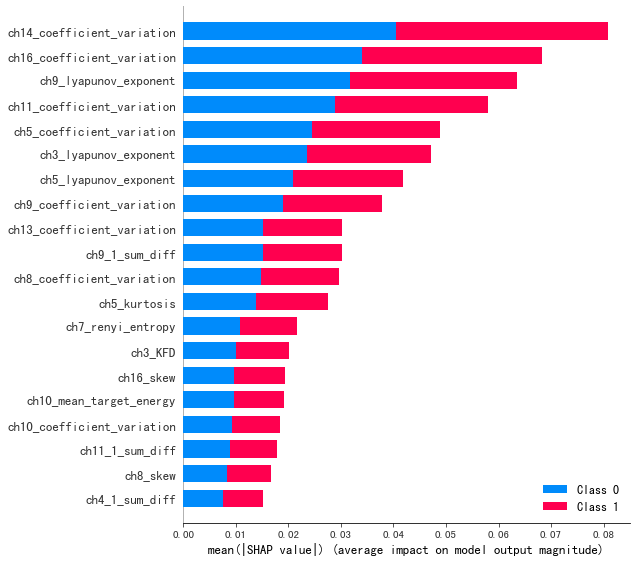

In [23]:
print("Variable Importance Plot - Global Interpretation") 
figure = plt.figure() 
shap.summary_plot(shap_values, x_test)

We can find that the contributions of these features to our classification results are basically the same. Interestingly, both lyapunov_exponent and coefficient_variation features play an important role in the expression of SHAP values.

Summary plot of specific classification results:

In [53]:
# shap.summary_plot(shap_interaction_values,x_test)

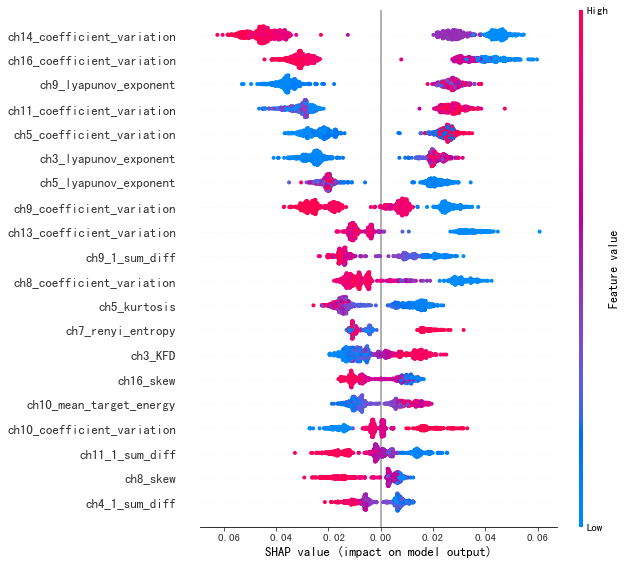

In [30]:
# Summary Plot Deep-Dive on Label 1 
shap.summary_plot(shap_values[1], x_test)

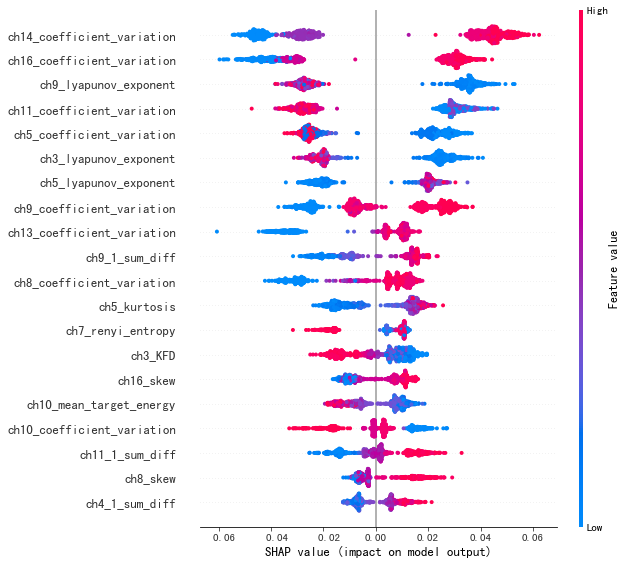

In [31]:
# Summary Plot Deep-Dive on Label 0
shap.summary_plot(shap_values[0], x_test)

In [32]:
# Dependence Plot on Age feature 
# shap.dependence_plot('ch3_KFD', shap_values[1], X_test, interaction_index="ch3_KFD'")

Demonstrate local result attribution for the first sample with thrust plots

In [24]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1][:])

In [25]:
col_name[758]

'ch14_coefficient_variation'

In [26]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1][:])

More samples

In [27]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:10])

In [28]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:10])

Show attribution of results for a single sample with a decision road map

In [68]:
# shap.decision_plot(explainer.expected_value[0], shap_values[0][1])

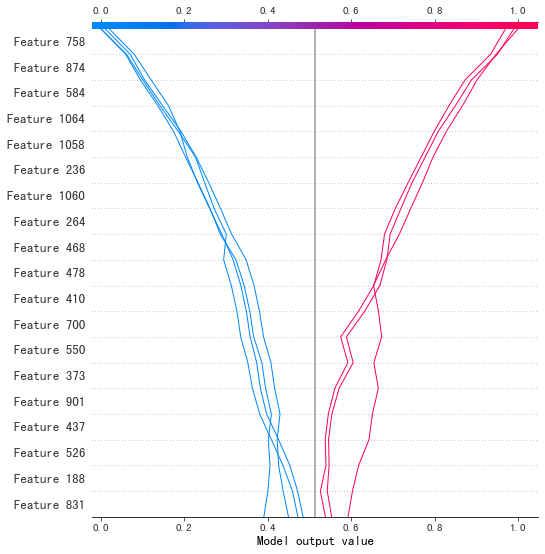

In [67]:
# Display attribution of results for a single sample (including interactions between features) through a decision road map
shap.decision_plot(explainer.expected_value[1],shap_interaction_values[1][0:7],feature_display_range=slice(None, -20, -1))

The visualizations are very interesting, but in essence the features they discuss are the ones we found earlier

#### LIME

It is short for Local Interpretable Model Agnostic Explanation. Local means that it can be used to explain individual predictions of a machine learning model.

In [29]:
# Import the LimeTabularExplainer module 
from lime.lime_tabular import LimeTabularExplainer 
 
# Get the class names, default 0 1
class_names = ['Imagination', 'Vision'] 
 
# Get the feature names 
feature_names = list(col_name) 
 
# Fit the Explainer on the training data set using the LimeTabularExplainer  
lime_explainer = LimeTabularExplainer(x_train, feature_names = feature_names,  
                                 class_names = class_names, discretize_continuous=False)

In [30]:
# Explaining 1-Sample Outcome Attribution with the LIME Interpreter
exp = lime_explainer.explain_instance(x_test.iloc[3,:], estimator.predict_proba)

In [31]:
# Impression attribution
exp.show_in_notebook(show_table=True, show_all=False)

This code will tell us for one example, how they get the final label.

And another interesting point, if we delete those features, could our model still figure out the right answer?(I won't test this idea...)

### DL models

As I asked before, can DL models learn those features automatically without feature extraction?

Let's try some basic NN such as RNN, LSTM ,GRU, CNN. In order to parallelize(batch size), the length of the signal here needs to be the same (can also use padding+mask).

In [27]:
from pipelines.data_prapare import read_power_band_txt,read_features_table, read_signal_data
from pipelines.ml_functions import prepare_signals

aat_vis_signal, aat_img_signal, asl_vis_signal, asl_img_signal = read_signal_data()
aat_vis_signal = prepare_signals(aat_vis_signal)
aat_img_signal = prepare_signals(aat_img_signal)
asl_vis_signal = prepare_signals(asl_vis_signal)
asl_img_signal = prepare_signals(asl_img_signal)

In [28]:
Y = to_categorical(np.array([*[0 for i in range(832*2)], *[1 for i in range(832*2)]]))
X = np.concatenate((asl_img_signal, aat_img_signal, asl_vis_signal, aat_vis_signal), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [29]:
x_train.shape

(2329, 346, 16)

Because of errors, I try to change my numpy version 1.20.0 to 1.19.2 

In [34]:
model = Sequential()
model.add(LSTM(256, input_shape=(346, 16)))
# model.add(Conv1D(16,4, input_shape=(346, 16), activation='relu'))
# model.add(Conv1D(4,2, activation='relu'))
# model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

In [35]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# model.summary()

In [37]:
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

Epoch 1/10
73/73 [==============================] - 0s 6ms/step - loss: 89.2299 - accuracy: 0.4891
Epoch 2/10
73/73 [==============================] - 0s 6ms/step - loss: 0.7150 - accuracy: 0.5002
Epoch 3/10
73/73 [==============================] - 0s 6ms/step - loss: 0.7049 - accuracy: 0.4839
Epoch 4/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4998
Epoch 5/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.5006
Epoch 6/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4938
Epoch 7/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4886
Epoch 8/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5002
Epoch 9/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4830
Epoch 10/10
73/73 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4912


In [38]:
y_pred = model.predict(x_test)

In [39]:
# y_pred
# y_test

In [40]:
# tf.metrics.Accuracy(y_test, y_pred)

In [41]:
# y_pred
# y_pred = [np.max(item) for item in y_pred ]
# tt = list()
# for i in y_pred:
#     if i >= 0.5:
#         tt.append(0)
#     else:
#         tt.append(1)      

In [2]:
# accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, y_pred)

### Analyze 

Can the model distinguish between imaginary and visual signals, and which features are important in distinguishing between these signals? For example, as a hypothetical, is vision more important than imagined for some signal strength characteristics? In the above process, we have obtained important features to distinguish between vision and imagination. What characteristics of signals do they mainly represent?

* coefficient_variation

https://en.wikipedia.org/wiki/Coefficient_of_variation

In probability theory and statistics, the coefficient of variation (CV), also known as relative standard deviation (RSD),is a standardized measure of dispersion of a probability distribution or frequency distribution. 
The coefficient of variation  is defined as the ratio of the standard deviation to the mean.

* lyapunov_exponent

https://en.wikipedia.org/wiki/Lyapunov_exponent

* KFD - katz fractal dimension

https://en.wikipedia.org/wiki/Fractal_dimension
https://fr.mathworks.com/matlabcentral/fileexchange/50290-higuchi-and-katz-fractal-dimension-measures

* 1_sum_diff

sum of first order derivatives

* renyi_entropy

https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy

* skew

https://en.wikipedia.org/wiki/Skewness

* kurtosis

https://en.wikipedia.org/wiki/Kurtosis

* BP, alpha/delta

Band power features.
https://en.wikipedia.org/wiki/Spectral_density

Another interesting finding: check the channel 16 3 13 position in brain area,does this result indicate that different areas of the brain work differently?

For now, our fist classification task has been finished, let us check other task with other important features, are those features always same? Feature coefficient_variation, lyapunov_exponent and etc always matter?

## Binary classification - ASL and Alphabet

### Model performances comparison

#### aat vis vs asl vis

What characteristics determine the difference between sign language and alphabetic signals? In our cognition, sign language A and letter A are actually both A. The only difference is the way of expression. Which signal features can better reflect the visual expression of different images in our cognitive process?

In [32]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary = np.concatenate((bp_asl_vis, bp_aat_vis), axis=0)
data_allfeature_binary = np.concatenate((asl_vis, aat_vis), axis=0)

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.507732        0.486   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.959622        0.956   
2        KNN           {'n_neighbors': 3}      0.977663        0.966   
3        XGB                      default      1.000000        0.996   
4       GBDT                      default      1.000000        0.998   
5        LGB                      default      1.000000        0.998   
6         DT                      default      1.000000        0.998   
7       AdaB                      default      1.000000        1.000   
8         RF                      default      1.000000        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.501202  0.505158          0.243000             0.486       0.500000   
1     0.958534  0.947657          0.956383             0.956       0.956383   
2     0.974159  0.944150          0.965884             0.966       0.966026   
3     0.998798  0.999145          0.996124             0.996       0.995902   
4     0.999399  0.999145          0.998113             0.998       0.997881   
5     0.999399  0.996552          0.998024             0.998       0.997984   
6     0.999399  0.995704          0.998016             0.998       0.997992   
7     1.000000  0.999145          1.000000             1.000       1.000000   
8     1.000000  1.000000          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.486         0.327052            0.486  
1          0.956         0.956000            0.956  
2          0.966         0.965951            0.966  
3          0.996         0.995997            0.996  
4          0.998         0.997993            0.998  
5          0.998         0.998000            0.998  
6          0.998         0.998000            0.998  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

In [33]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0       AdaB                      default           1.0        0.992   
1       GBDT                      default           1.0        0.996   
2         DT                      default           1.0        0.996   
3        SVM                      default           1.0        1.000   
4         LR  {'C': 0.1, 'penalty': 'l2'}           1.0        1.000   
5        KNN                      default           1.0        1.000   
6         RF                      default           1.0        1.000   
7        XGB                      default           1.0        1.000   
8        LGB                      default           1.0        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.997596  0.999145          0.991917             0.992       0.992106   
1     0.998798  0.998283          0.996000             0.996       0.996000   
2     0.998798  0.995704          0.996000             0.996       0.996000   
3     1.000000  1.000000          1.000000             1.000       1.000000   
4     1.000000  1.000000          1.000000             1.000       1.000000   
5     1.000000  1.000000          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  0.997429          1.000000             1.000       1.000000   
8     1.000000  0.998283          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.992         0.991995            0.992  
1          0.996         0.996000            0.996  
2          0.996         0.996000            0.996  
3          1.000         1.000000            1.000  
4          1.000         1.000000            1.000  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

The difference from the previous binary classification task is that, two training features both work.

We could also know, distinguishing between sign language and alphabetic signals is a very simple task.

#### asl img vs asl img

In [34]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary = np.concatenate((bp_asl_img, bp_aat_img), axis=0)
data_allfeature_binary = np.concatenate((asl_img, aat_img), axis=0)

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.507732        0.492   
1        KNN           {'n_neighbors': 3}      0.961340        0.904   
2         LR  {'C': 0.1, 'penalty': 'l2'}      0.951031        0.960   
3         DT                      default      1.000000        0.992   
4        XGB                      default      1.000000        0.996   
5       GBDT                      default      1.000000        0.998   
6       AdaB                      default      1.000000        1.000   
7         RF                      default      1.000000        1.000   
8        LGB                      default      1.000000        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.503005  0.498298          0.744980             0.492       0.503906   
1     0.944111  0.926105          0.904295             0.904       0.904425   
2     0.953726  0.942448          0.960305             0.960       0.959951   
3     0.997596  0.990525          0.991379             0.992       0.992647   
4     0.998798  0.999138          0.995833             0.996       0.996183   
5     0.999399  0.994842          0.998175             0.998       0.997797   
6     1.000000  0.998276          1.000000             1.000       1.000000   
7     1.000000  0.999138          1.000000             1.000       1.000000   
8     1.000000  0.995697          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.492         0.336593            0.492  
1          0.904         0.903998            0.904  
2          0.960         0.959990            0.960  
3          0.992         0.991948            0.992  
4          0.996         0.995992            0.996  
5          0.998         0.997982            0.998  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

In [35]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        XGB                      default           1.0        0.994   
1       GBDT                      default           1.0        0.996   
2         DT                      default           1.0        0.996   
3       AdaB                      default           1.0        0.998   
4        SVM                      default           1.0        1.000   
5         LR  {'C': 0.1, 'penalty': 'l2'}           1.0        1.000   
6        KNN                      default           1.0        1.000   
7         RF                      default           1.0        1.000   
8        LGB                      default           1.0        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.998197  0.998283          0.993890             0.994       0.994088   
1     0.998798  1.000000          0.995992             0.996       0.995992   
2     0.998798  0.989699          0.995851             0.996       0.996169   
3     0.999399  0.993133          0.997984             0.998       0.998024   
4     1.000000  1.000000          1.000000             1.000       1.000000   
5     1.000000  1.000000          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  1.000000          1.000000             1.000       1.000000   
8     1.000000  0.997414          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.994         0.993985            0.994  
1          0.996         0.995992            0.996  
2          0.996         0.995994            0.996  
3          0.998         0.998000            0.998  
4          1.000         1.000000            1.000  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

Same conclusion like the first one.

#### asl vs aat

In [36]:
labels_binary = [*[0 for i in range(832*2)], *[1 for i in range(832*2)]]
data_bp_binary = np.concatenate((bp_asl_img,bp_asl_vis,bp_aat_img, bp_aat_vis), axis=0)
data_allfeature_binary = np.concatenate((asl_img,asl_vis,aat_img, aat_vis), axis=0)

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.513525     0.520521   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.931301     0.923924   
2        KNN                      default      0.963504     0.935936   
3         DT                      default      1.000000     0.993994   
4       GBDT                      default      1.000000     0.998999   
5        XGB                      default      1.000000     0.998999   
6       AdaB                      default      1.000000     1.000000   
7         RF                      default      1.000000     1.000000   
8        LGB                      default      1.000000     1.000000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.515625  0.501929          0.655934          0.520521       0.518169   
1     0.929087  0.936882          0.928709          0.923924       0.925716   
2     0.955228  0.945473          0.935642          0.935936       0.937328   
3     0.998197  0.994417          0.994037          0.993994       0.993982   
4     0.999700  0.997854          0.998982          0.998999       0.999018   
5     0.999700  1.000000          0.999014          0.998999       0.998986   
6     1.000000  0.999571          1.000000          1.000000       1.000000   
7     1.000000  1.000000          1.000000          1.000000       1.000000   
8     1.000000  0.999569          1.000000          1.000000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0       0.520521         0.382726         0.520521  
1       0.923924         0.923860         0.923924  
2       0.935936         0.935848         0.935936  
3       0.993994         0.993994         0.993994  
4       0.998999         0.998999         0.998999  
5       0.998999         0.998999         0.998999  
6       1.000000         1.000000         1.000000  
7       1.000000         1.000000         1.000000  
8       1.000000         1.000000         1.000000

In [37]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_allfeature_binary, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0         DT                      default           1.0     0.993994   
1       GBDT                      default           1.0     0.997998   
2        SVM                      default           1.0     1.000000   
3         LR  {'C': 0.1, 'penalty': 'l2'}           1.0     1.000000   
4        KNN                      default           1.0     1.000000   
5       AdaB                      default           1.0     1.000000   
6         RF                      default           1.0     1.000000   
7        XGB                      default           1.0     1.000000   
8        LGB                      default           1.0     1.000000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.998197  0.996137          0.994004          0.993994       0.993992   
1     0.999399  0.998283          0.997997          0.997998       0.997997   
2     1.000000  1.000000          1.000000          1.000000       1.000000   
3     1.000000  1.000000          1.000000          1.000000       1.000000   
4     1.000000  1.000000          1.000000          1.000000       1.000000   
5     1.000000  1.000000          1.000000          1.000000       1.000000   
6     1.000000  1.000000          1.000000          1.000000       1.000000   
7     1.000000  1.000000          1.000000          1.000000       1.000000   
8     1.000000  1.000000          1.000000          1.000000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0       0.993994         0.993994         0.993994  
1       0.997998         0.997997         0.997998  
2       1.000000         1.000000         1.000000  
3       1.000000         1.000000         1.000000  
4       1.000000         1.000000         1.000000  
5       1.000000         1.000000         1.000000  
6       1.000000         1.000000         1.000000  
7       1.000000         1.000000         1.000000  
8       1.000000         1.000000         1.000000

### Band power comparison

for aat vis vs asl vis, compare BP features' performance

In [23]:
labels_binary = [*[0 for i in range(832)], *[1 for i in range(832)]]
data_bp_binary_2 = np.concatenate((bp_asl_vis_fft, bp_aat_vis_fft), axis=0)
data_bp_binary_3 = np.concatenate((bp_asl_vis_multitaper, bp_aat_vis_multitaper), axis=0)

FFT:

In [24]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary_2, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.521478        0.474   
1         LR  {'C': 0.1, 'penalty': 'l2'}      0.913230        0.898   
2        KNN           {'n_neighbors': 6}      0.939863        0.902   
3         DT                      default      1.000000        0.986   
4        XGB                      default      1.000000        0.998   
5       GBDT                      default      1.000000        1.000   
6       AdaB                      default      1.000000        1.000   
7         RF                      default      1.000000        1.000   
8        LGB                      default      1.000000        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.507212  0.511170          0.553356             0.474       0.504611   
1     0.908654  0.916689          0.900574             0.898       0.897529   
2     0.928486  0.913285          0.902464             0.902       0.901607   
3     0.995793  0.993133          0.986156             0.986       0.986040   
4     0.999399  0.999138          0.998069             0.998       0.997934   
5     1.000000  0.999145          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  1.000000          1.000000             1.000       1.000000   
8     1.000000  0.995712          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.474         0.343390            0.474  
1          0.898         0.897744            0.898  
2          0.902         0.901858            0.902  
3          0.986         0.985999            0.986  
4          0.998         0.997998            0.998  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

Multitaper:

In [26]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_bp_binary_3, labels_binary, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

Classifier                        param  Traing score   Test Score  \
0        SVM                      default      0.513746        0.476   
1        KNN           {'n_neighbors': 4}      0.969072        0.946   
2         LR  {'C': 0.1, 'penalty': 'l2'}      0.962199        0.946   
3         DT                      default      1.000000        0.988   
4       GBDT                      default      1.000000        1.000   
5       AdaB                      default      1.000000        1.000   
6         RF                      default      1.000000        1.000   
7        XGB                      default      1.000000        1.000   
8        LGB                      default      1.000000        1.000   

   Whole score  CV Score  Precision(Macro)  Precision(Micro)  Recall(Macro)  \
0     0.502404  0.509439          0.487952             0.476       0.499808   
1     0.962139  0.947569          0.946435             0.946       0.945885   
2     0.957332  0.956211          0.946574             0.946       0.946338   
3     0.996394  0.995704          0.987897             0.988       0.988116   
4     1.000000  0.997421          1.000000             1.000       1.000000   
5     1.000000  1.000000          1.000000             1.000       1.000000   
6     1.000000  1.000000          1.000000             1.000       1.000000   
7     1.000000  0.997421          1.000000             1.000       1.000000   
8     1.000000  0.997429          1.000000             1.000       1.000000   

   Recall(Micro)  F1 Score(Macro)  F1 Score(Micro)  
0          0.476         0.325799            0.476  
1          0.946         0.945974            0.946  
2          0.946         0.945998            0.946  
3          0.988         0.987991            0.988  
4          1.000         1.000000            1.000  
5          1.000         1.000000            1.000  
6          1.000         1.000000            1.000  
7          1.000         1.000000            1.000  
8          1.000         1.000000            1.000

We could find for this task, all three BP features work well.

During the analysis(feature importance) process in Chapter 3, I will not repeat every process in Chapter 2.

### BP Feature importance

Since the feature importance of the LR model is just the coefficient of the regression equation, I will only test the random forest and SHAP values.

Besides, because all task work well, so I will just analyze the whole set ---> ASL (img and vis) compare Alphabet (img and vis).

In [79]:
labels_binary = [*[0 for i in range(832*2)], *[1 for i in range(832*2)]]
data_bp_binary = np.concatenate((bp_asl_img,bp_asl_vis,bp_aat_img, bp_aat_vis), axis=0)
data_allfeature_binary = np.concatenate((asl_img,asl_vis,aat_img, aat_vis), axis=0)

In [80]:
ch_names=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8','ch9', 'ch10',
              'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16']
band_name = ["δ-delta" , "θ-theta" , "α-alpha" , "β-beta" , "γ-gamma"]   
bp_col_names = [i+'_'+j for i in ch_names for j in band_name]

In [81]:
estimator = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_bp_binary, labels_binary, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {bp_col_names[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# t1, t2 = binary_models_print(estimator, is_bp_features=True)

1.0


In [82]:
np.median(feat_importance)
np.min(feat_importance)
np.max(feat_importance)

0.08335481342071453

See the top 10/20 features directly:

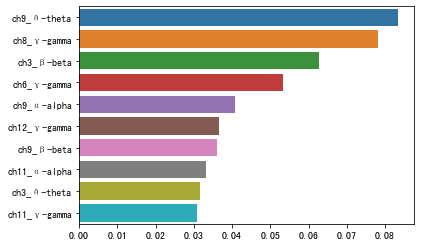

In [83]:
# fe_list[0:20]
tt = fe_list[0:10]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

Top BP features are gamma, theta, beta. In top 10/20, barely no delta.

Compare the results obtained by SHAP values:

Variable Importance Plot - Global Interpretation


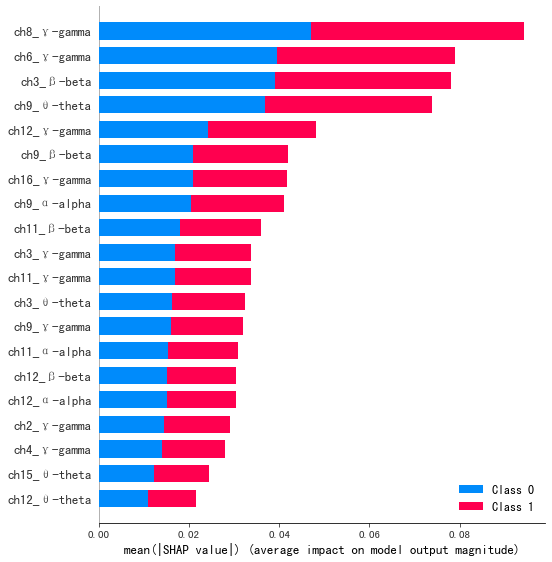

In [92]:
# load JS visualization code to notebook 
shap.initjs() 

# Create the explainer /  estimator here, are the RF model above, data 3, label 3
explainer = shap.TreeExplainer(estimator) 

x_test = pd.DataFrame(x_test, columns=bp_col_names)
shap_values = explainer.shap_values(x_test)
shap_interaction_values = explainer.shap_interaction_values(x_test)


print("Variable Importance Plot - Global Interpretation") 
figure = plt.figure() 
shap.summary_plot(shap_values, x_test)

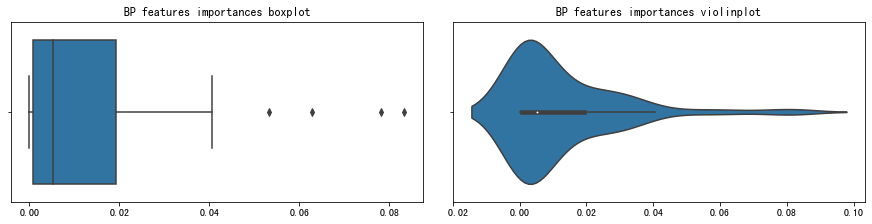

In [84]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value, ax=ax[0])
axesSub.set_title('BP features importances boxplot')
axesSub = sns.violinplot(fe_list_value, ax=ax[1])
axesSub.set_title('BP features importances violinplot')
plt.show()

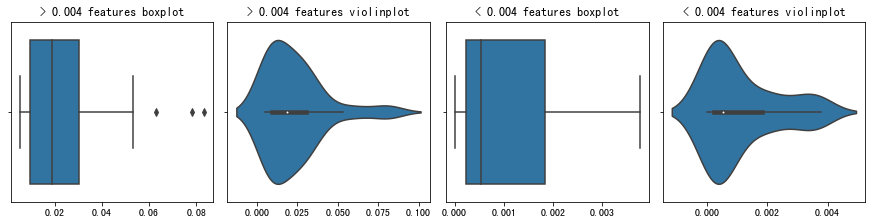

In [85]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

big, small = threshold_list(fe_list_value, threshold=0.004)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.004 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.004 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.004 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.004 features violinplot')
plt.show()

In [86]:
threshold = 0.004

RF_df_original = dict()
RF_df_original['channel'] = list()
RF_df_original['fe_names'] = list()
RF_df_original['fe_values'] = list()
RF_df_original['full_names'] = list()

for item in fe_list:
    if np.abs(item[1]) >= threshold:
        tt = item[0].split('_')
        RF_df_original['full_names'].append(item[0])
        RF_df_original['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_values'].append(item[1])
        

RF_df_original = pd.DataFrame(RF_df_original)

In [88]:
tt = RF_df_original[['fe_names', 'fe_values']].groupby('fe_names')
tt =tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(5,)

pp = RF_df_original[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

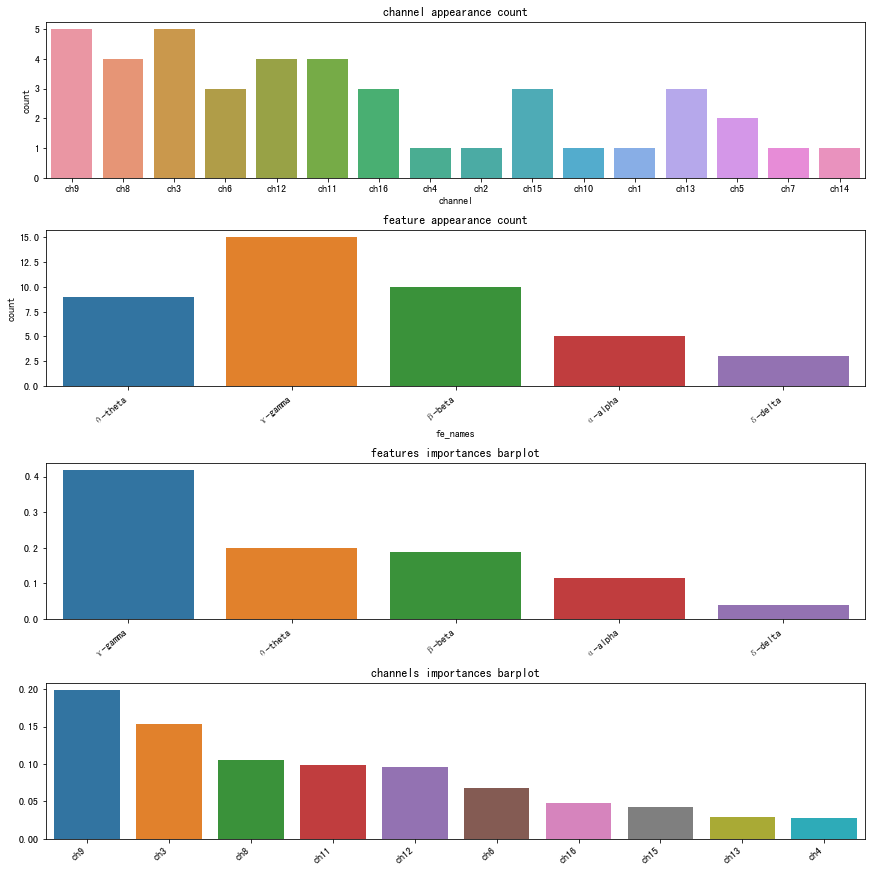

In [89]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

We can find that channel 9 and channel 3 not only have more features that exceed the threshold, but also have more weights.

The same is true for the gamma feature, the larger the number, the larger the weight.

(You can learn more about what the gamma feature represents, and then in the previous notebook.)

### ALL Feature importance

In [95]:
estimator = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(data_allfeature_binary, labels_binary, test_size=0.3)
estimator.fit(x_train, y_train)
print(estimator.score(x_test, y_test))
    
# feat_importance = estimator.tree_.compute_feature_importances(normalize=False)
feat_importance = estimator.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# t1, t2 = binary_models_print(estimator, is_bp_features=True)

1.0


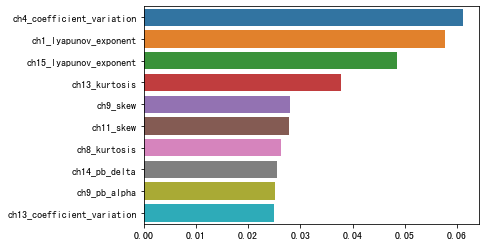

In [98]:
# fe_list[0:20]
tt = fe_list[0:10]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

Compare with SHAP values' results

Variable Importance Plot - Global Interpretation


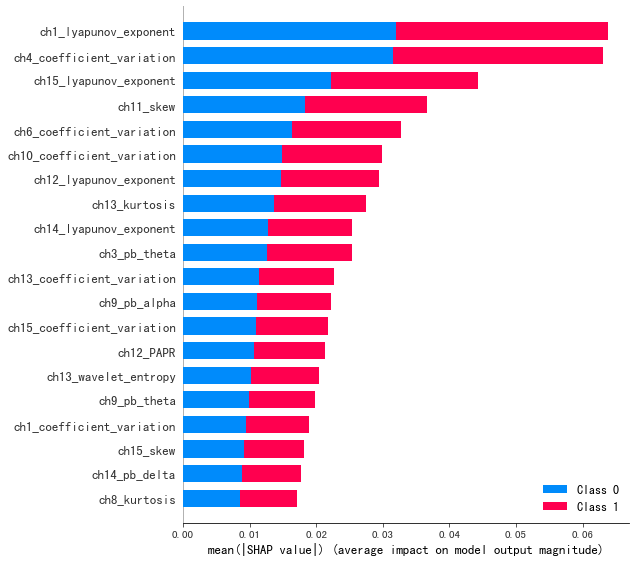

In [100]:
# load JS visualization code to notebook 
shap.initjs() 

# Create the explainer /  estimator here, are the RF model above, data 3, label 3
explainer = shap.TreeExplainer(estimator) 

x_test = pd.DataFrame(x_test, columns=col_name)
shap_values = explainer.shap_values(x_test)
shap_interaction_values = explainer.shap_interaction_values(x_test)


print("Variable Importance Plot - Global Interpretation") 
figure = plt.figure() 
shap.summary_plot(shap_values, x_test)

We can find that among these decisive features, the types of features are basically the same, but there may be some differences in the channels of the features. For example, there is no channel 16 here, but there are still 13. This is also due to the different positions (May correspond to different brain functions)corresponding to different channels. 

At the same time, we can also find that in this task, BP features can already achieve very good classification results, but their feature importance is not ranked very high. Compared with task 1, BP features cannot make our samples get a very good classification.

So, not always BP matters.

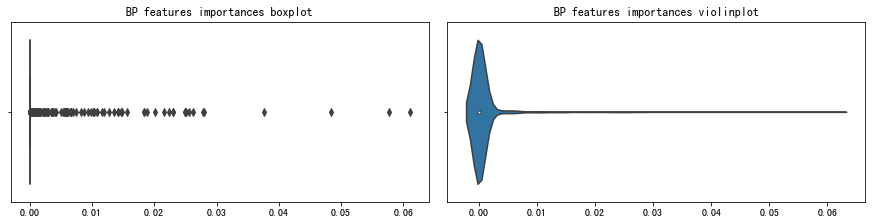

In [101]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value, ax=ax[0])
axesSub.set_title('BP features importances boxplot')
axesSub = sns.violinplot(fe_list_value, ax=ax[1])
axesSub.set_title('BP features importances violinplot')
plt.show()

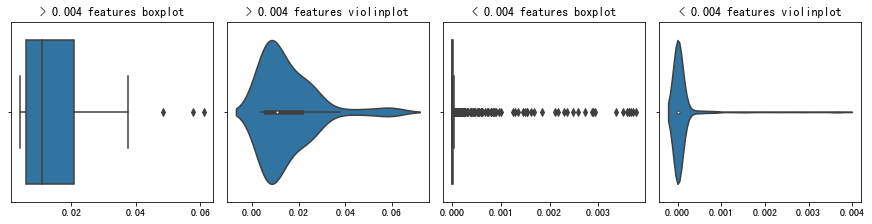

In [102]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

big, small = threshold_list(fe_list_value, threshold=0.004)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.004 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.004 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.004 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.004 features violinplot')
plt.show()

In [105]:
threshold = 0.004

RF_df_original = dict()
RF_df_original['channel'] = list()
RF_df_original['fe_names'] = list()
RF_df_original['fe_values'] = list()
RF_df_original['full_names'] = list()

for item in fe_list:
    if np.abs(item[1]) >= threshold:
        tt = item[0].split('_')
        RF_df_original['full_names'].append(item[0])
        RF_df_original['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_values'].append(item[1])
        

RF_df_original = pd.DataFrame(RF_df_original)

tt = RF_df_original[['fe_names', 'fe_values']].groupby('fe_names')
tt =tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(10,)

pp = RF_df_original[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

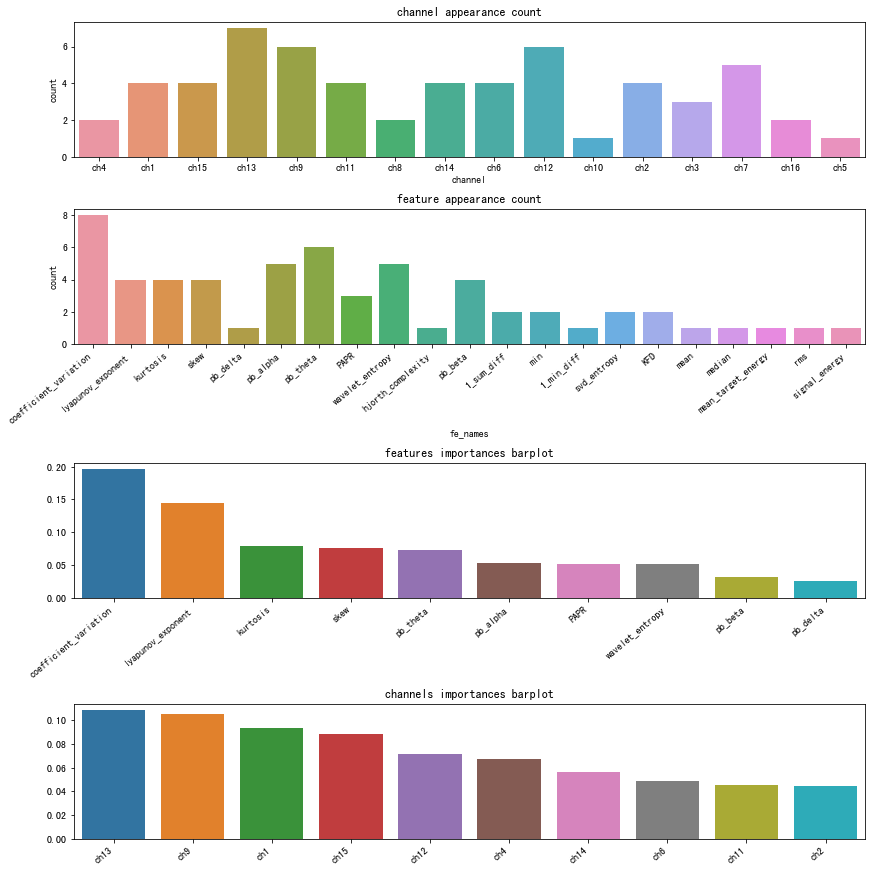

In [106]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

Channels 13 9 12 7 have more over-threshold features;

In addition to features such as skewness, coefficient_variation, lyapunov_exponent, kurtosis, the number of BP features(theta, alpha, beta) is also large.

Of course, the number of features is only a part. We can observe the feature weights in the barh graph. We can observe more clearly which features are more important and which channels have a larger proportion (of course, this is not absolute, you must know that we only use BP features can also lead to a very good conclusion).

### DL models

Same questions: Let's check can basic NN learn those features:

In [42]:
from pipelines.data_prapare import read_power_band_txt,read_features_table, read_signal_data
from pipelines.ml_functions import prepare_signals

aat_vis_signal, aat_img_signal, asl_vis_signal, asl_img_signal = read_signal_data()
aat_vis_signal = prepare_signals(aat_vis_signal)
aat_img_signal = prepare_signals(aat_img_signal)
asl_vis_signal = prepare_signals(asl_vis_signal)
asl_img_signal = prepare_signals(asl_img_signal)

Y = np.array([*[0 for i in range(832*2)], *[1 for i in range(832*2)]])
X = np.concatenate((asl_img_signal, asl_vis_signal, aat_img_signal, aat_vis_signal), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)



In [43]:
model = Sequential()
# model.add(SimpleRNN(256, input_shape=(346, 16)))
# model.add(LSTM(256, input_shape=(346, 16)))
model.add(Conv1D(16,4, input_shape=(346, 16), activation='relu'))
model.add(Conv1D(4,2, activation='relu'))
model.add(Flatten())
# model.add(Dense(2,activation='sigmoid'))
model.add(Dense(2))

model.compile(optimizer='Adam', loss='binary_crossentropy')

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

Epoch 1/10
73/73 [==============================] - 0s 6ms/step - loss: 7.4525
Epoch 2/10
73/73 [==============================] - 0s 7ms/step - loss: 7.6686
Epoch 3/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 4/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 5/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 6/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 7/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 8/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 9/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686
Epoch 10/10
73/73 [==============================] - 0s 6ms/step - loss: 7.6686


In [44]:
y_pred = model.predict(x_test)
y_pred = [np.max(item) for item in y_pred ]
tt = list()
for i in y_pred:
    if np.abs(i) >= 0.5:
        tt.append(0)
    else:
        tt.append(1)
accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, tt)      

accuracy: 0.501
f1 score macro av: 0.334
recall score macro av: 0.500
precision score macro av: 0.250
f1 score for every class:  [0.66711141 0.        ]
recall:  [1. 0.]
precision:  [0.5005005 0.       ]
 


In [121]:
# y_pred

### Analyze

Compare the section 2.5, there are only some new features here, most of the other features are the same as the previous task

* PAPR
peak-to-average ratio

https://en.wikipedia.org/wiki/Crest_factor
The peak-to-average power ratio (PAPR) is the peak amplitude squared (giving the peak power) divided by the RMS value squared (giving the average power). It is the square of the crest factor.

https://www.everythingrf.com/community/what-is-peak-to-average-power-ratio#:~:text=Peak%2Dto%2DAverage%20Power%20Ratio%20(PAPR)%20is%20defined,efficient%20performance%20of%20a%20system.

* wavelet entropy
calculated after level 5 wavelet decomposition

https://www.mdpi.com/journal/entropy/special_issues/wavelet-entropy


* BP, theta, alpha, beta, delta

In conclusion, BP features are sufficient for some classification tasks, but for other tasks they are not yet able to express all the features of EEG signals or that is, they are not always robust features.